# DCGAN - Anime Faces

This notebook demonstrates how to generate images of anime faces using a Deep Convolutional Generative Adversarial Network (DCGAN). 

The dataset was downloaded from kaggle site: https://www.kaggle.com/soumikrakshit/anime-faces. 

Generative Adversarial Networks (GANs) are one of the most interesting ideas in computer science today. Two models are trained simultaneously by an adversarial process. A generator ("the fraud") learns to create images that look real, while a discriminator ("judge") learns to tell real images apart from fakes.

During training, the generator progressively becomes better at creating images that look real, while the discriminator becomes better at telling them apart. The process reaches equilibrium when the discriminator can no longer distinguish real images from fakes.





## 1. Package importing.

In [1]:
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense, Flatten, LeakyReLU, Conv2D, Conv2DTranspose
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam

import seaborn
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs

from tqdm.notebook import tqdm
import imageio
import glob
import numpy as np
from PIL import Image

## 2. Architecture and utilities.

Both the generator and discriminator are defined using the Keras Functional API. The generator uses Conv2D and Conv2DTranspose (upsampling) layers to produce an image from a seed (random noise). Start with a Dense layer that takes this seed as input, then upsample several times until you reach the desired image size of 64x64x3. The LeakyReLU activation function for each layer, except the output layer which uses tanh.

In [2]:
def make_generator(noise_shape):
    
    #The Adam optimization algorithm
    optimizer = Adam(lr=0.00015, beta_1=0.5)
    
    generator_input = Input(shape=(noise_shape))
    
    # fully conected layers
    g = Dense(128 * 32 * 32)(generator_input) 
    # Leaky ReLU activation
    g = LeakyReLU()(g) 
    g = Reshape((32, 32, 128))(g)
    
    # 2D convolution layer with 256 filters and kernel size 5
    g = Conv2D(256, 5, padding='same')(g) 
    g = LeakyReLU()(g)
    # Transposed convolution layer with 256 filters kernel size 4 and strides 2
    g = Conv2DTranspose(256, 4, strides=2, padding='same')(g) 
    g = LeakyReLU()(g)

    g = Conv2D(256, 5, padding='same')(g)
    g = LeakyReLU()(g)
    g = Conv2D(256, 5, padding='same')(g)
    g = LeakyReLU()(g)

    g = Conv2D(3, 7, activation='tanh', padding='same')(g)

    generator_model = Model(generator_input, g)
    generator_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    print(20*'*' + ' Generator model '+ 20*'*')
    generator_model.summary()

    return generator_model

The discriminator is a CNN-based image classifier.

In [3]:
def make_discriminator(image_shape):
    
    optimizer = Adam(lr=0.0002, beta_1=0.5)

    discriminator_input = Input(shape=image_shape)
    d = Conv2D(128, 3)(discriminator_input)
    d = LeakyReLU()(d)
    
    d = Conv2D(128, 4, strides=2)(d)
    d = LeakyReLU()(d)
    
    d = Conv2D(128, 4, strides=2)(d)
    d = LeakyReLU()(d)
    
    d = Conv2D(128, 4, strides=2)(d)
    d = LeakyReLU()(d)
    
    # Flatten the input image
    d = Flatten()(d)
    #Droping out units to prevent over-fitting
    d = Dropout(0.4)(d)
    
    # Output layer with sigmoid activation
    d = Dense(1, activation='sigmoid')(d)

    discriminator_model = Model(discriminator_input, d)
    discriminator_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    print(20*'*' + ' Discriminator model '+ 20*'*')
    discriminator_model.summary()
    
    return discriminator_model

In [4]:
def norm_img(img):
    '''Image normalisation to keep values between -1 and 1 for stability.'''
    images = np.array(img)
    images = (images / 127.5) - 1
    images = images.astype('float32')
    return images

def denorm_img(img):
    '''Image transformation to original.'''
    img = (img + 1) * 127.5
    return img.astype(np.uint8)

def get_data():
    '''Importing data from a working directory'''
    all_images = []
    for index, filename in enumerate(glob.glob(data_dir)):
        image = imageio.imread(filename, as_gray=False, pilmode='RGB')
        all_images.append(image)
        
    return norm_img(all_images)

DCGAN Model

In [5]:
def make_gan(g, d):
    optimizer = Adam(lr=0.00015, beta_1=0.5)
    
    # Combined Generator -> Discriminator model
    generator_input = Input(shape=noise_shape)
    gan_input = g(generator_input)
    gan_output = d(gan_input)
    
    gan = Model(generator_input, gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    print(10*'*' + ' Generative Adversarial Networks Model '+ 10*'*'   )
    gan.summary()
    
    return gan

## 3. Model and data loading.

In [6]:
noise_shape = (1, 1, 100)
image_shape = (64,64,3)

discriminator = make_discriminator(image_shape=image_shape)
generator = make_generator(noise_shape=noise_shape)
# Keep Discriminator’s parameters constant for Generator training
discriminator.trainable = False

# Build and compile DCGAN model with fixed Discriminator to train the Generator
gan = make_gan(generator, discriminator)

******************** Discriminator model ********************
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 62, 62, 128)       3584      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 62, 62, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 128)       262272    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 128)       262272    
_________________________________________________________________

In [7]:
noise_dim = 100
EPOCHS = 10000
batch_size = 128

data_dir = 'D:/DATASET/animefaces/*.*'
save_images_dir = 'D:/projekt_output/Images/'
save_model_dir = 'D:/projekt_output/Model/'
save_gif_dir = 'D:/projekt_output/Gif/'

In [8]:
X = get_data()

In [9]:
discriminator_fake_losses = []
discriminator_real_losses = []
gan_losses = []

In [10]:
data_dir = 'D:/DATASET/animefaces/*.*'
save_images_dir = 'D:/projekt_output/Images1/'
save_model_dir = 'D:/projekt_output/Model1/'
save_gif_dir = 'D:/projekt_output/Gif/'

### Training loop

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

We use tqdm library to display an extensible progress bar and run it for 10 000 epochs. We can see, the model learning process took 12 hours and 40 minutes.

In [11]:
for epoch in tqdm(range(EPOCHS)):

    print(f"Epoch: {epoch}/{EPOCHS}")
    
    # Get a random batch of real images
    idx = np.random.randint(0, X.shape[0], batch_size)
    real_data_X = X[idx]
    
    # Generate a batch of fake images
    noise = np.random.normal(0, 1, size=(batch_size,) + noise_shape)
    fake_data_X = generator.predict(noise)

    if (epoch % 50) == 0:
        plt.figure(figsize=(8, 8))
        gs1 = gs.GridSpec(8, 8)
        gs1.update(wspace=0, hspace=0)
        random_indices = np.random.choice(fake_data_X.shape[0], 64, replace=False)
        for i in range(64):
            ax1 = plt.subplot(gs1[i])
            ax1.set_aspect('equal')
            random_index = random_indices[i]
            image = fake_data_X[random_index, :, :, :]
            fig = plt.imshow(denorm_img(image))
            plt.axis('off')
            fig.axes.get_xaxis().set_visible(False)
            fig.axes.get_yaxis().set_visible(False)
        plt.tight_layout()
        plt.savefig(save_images_dir + str(epoch).zfill(5) + "_image.png", bbox_inches='tight', pad_inches=0)
        plt.close()

    # concatenate real and fake data samples
    data_X = np.concatenate([real_data_X, fake_data_X])
    #add noise to the label inputs
    real_data_Y = np.ones(batch_size) - np.random.random_sample(batch_size) * 0.2
    fake_data_Y = np.random.random_sample(batch_size) * 0.2

    data_Y = np.concatenate((real_data_Y, fake_data_Y))

    discriminator.trainable = True
    generator.trainable = False
    
    ''' Training the Discriminator'''
    
    dis_metrics_real = discriminator.train_on_batch(real_data_X, real_data_Y)
    dis_metrics_fake = discriminator.train_on_batch(fake_data_X, fake_data_Y)

    print("Discriminator: real loss: %f fake loss: %f" % (dis_metrics_real[0], dis_metrics_fake[0]))

    discriminator_fake_losses.append(dis_metrics_fake[0])
    discriminator_real_losses.append(dis_metrics_real[0])
    
    ''' Training the Generator '''
    
    generator.trainable = True

    GAN_X = np.random.normal(0, 1, size=(batch_size,) + noise_shape)

    GAN_Y = real_data_Y

    discriminator.trainable = False

    gan_metrics = gan.train_on_batch(GAN_X, GAN_Y)
    print("GAN loss: %f" % (gan_metrics[0]))

    text_file = open(save_model_dir + "\\training_log.txt", "a")
    text_file.write("Epoch: %d Discriminator: real loss: %f fake loss: %f GAN loss: %f\n" % (epoch, 
                                                                                             dis_metrics_real[0],
                                                                                             dis_metrics_fake[0], 
                                                                                             gan_metrics[0]))
    text_file.close()
    gan_losses.append(gan_metrics[0])
    
    if ((epoch + 1) % 500) == 0:
        discriminator.trainable = True
        generator.trainable = True
        generator.save(save_model_dir + str(epoch) + "_GENERATOR.hdf5")
        discriminator.save(save_model_dir + str(epoch) + "_DISCRIMINATOR.hdf5")

Epoch: 0/10000
Discriminator: real loss: 0.730529 fake loss: 0.695024
GAN loss: 0.691978
Epoch: 1/10000
Discriminator: real loss: 0.572868 fake loss: 0.703444
GAN loss: 0.683013
Epoch: 2/10000
Discriminator: real loss: 0.448523 fake loss: 0.763911
GAN loss: 0.640870
Epoch: 3/10000
Discriminator: real loss: 0.353723 fake loss: 0.992493
GAN loss: 0.612394
Epoch: 4/10000
Discriminator: real loss: 0.380983 fake loss: 0.850028
GAN loss: 0.899783
Epoch: 5/10000
Discriminator: real loss: 0.445472 fake loss: 0.580393
GAN loss: 1.020942
Epoch: 6/10000
Discriminator: real loss: 0.461162 fake loss: 0.659743
GAN loss: 0.787742
Epoch: 7/10000
Discriminator: real loss: 0.522277 fake loss: 0.765486
GAN loss: 0.684660
Epoch: 8/10000
Discriminator: real loss: 0.387461 fake loss: 0.781163
GAN loss: 0.681944
Epoch: 9/10000
Discriminator: real loss: 0.357878 fake loss: 0.706770
GAN loss: 0.765790
Epoch: 10/10000
Discriminator: real loss: 0.353727 fake loss: 0.626316
GAN loss: 0.835523
Epoch: 11/10000
Disc

In [13]:
import pandas as pd

In [15]:
''' Exporting the results to csv'''

df = pd.DataFrame({
        'epochs': list(range(EPOCHS)),
        'disc_fake_loss': discriminator_fake_losses,
        'disc_real_loss': discriminator_real_losses,
        'gan_loss': gan_losses
    }).set_index('epochs')

In [75]:
df['mean_disc_loss'] = (df.disc_fake_loss + df.disc_real_loss) / 2

In [17]:
df.to_csv(save_model_dir+'losses.csv')

## 4. Creating charts, images and gif.

In [26]:
seaborn.set_style('darkgrid')

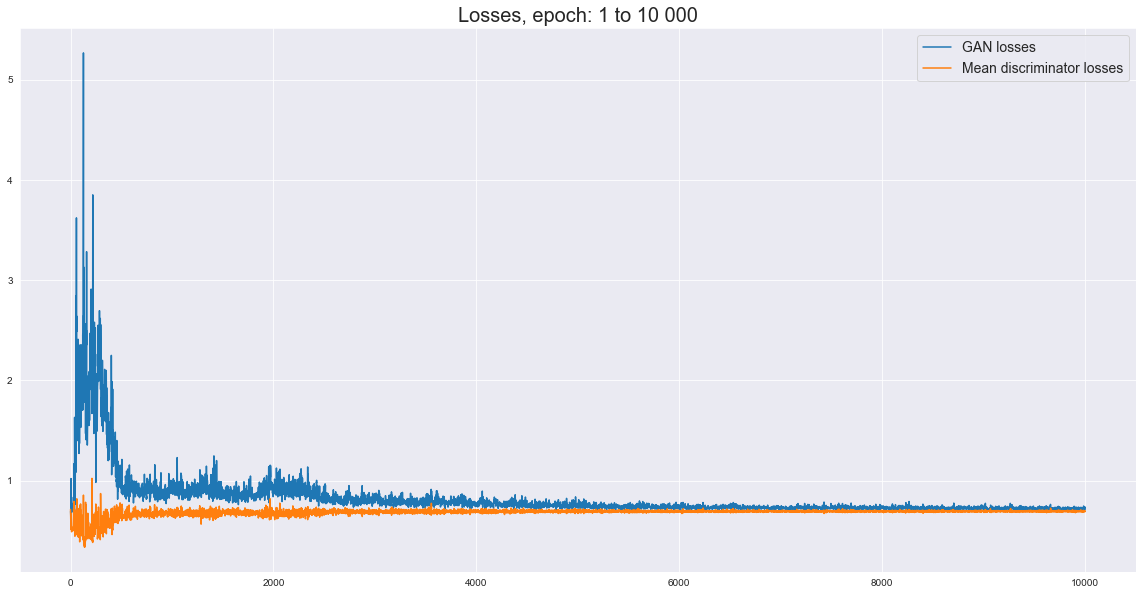

In [67]:
plt.figure(figsize=(20,10))
plt.plot(df['gan_loss'], label='GAN losses')
plt.plot(df['mean_disc_loss'], label='Mean discriminator losses')
plt.legend(loc=1,prop={'size': 14})
plt.title('Losses, epoch: 1 to 10 000', fontsize=20)
plt.show()

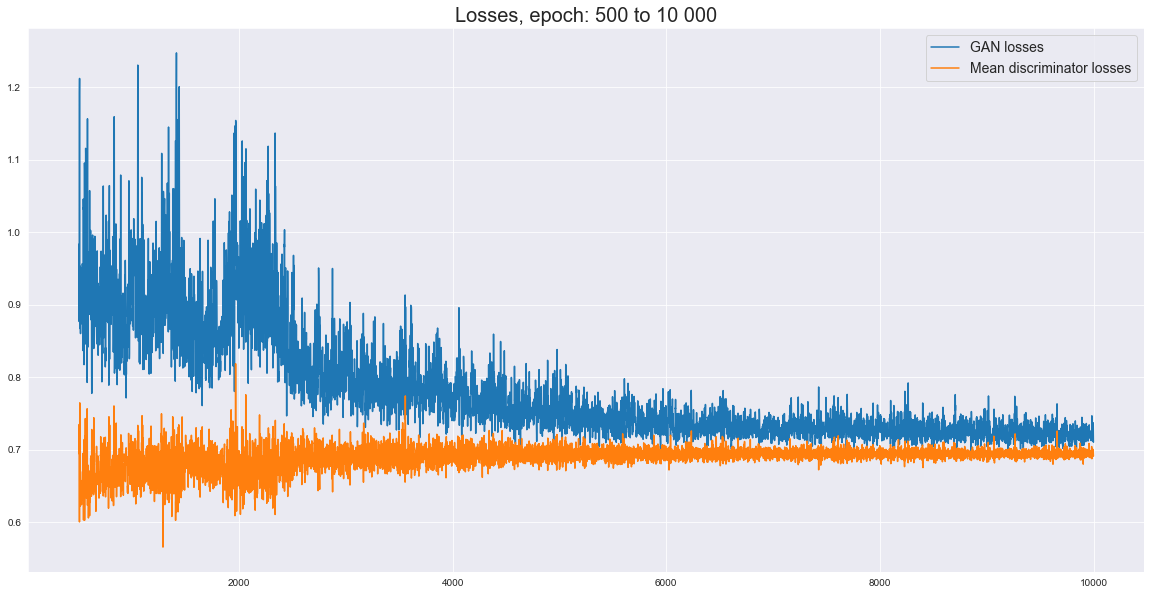

In [68]:
plt.figure(figsize=(20,10))
plt.plot(df['gan_loss'][500:], label='GAN losses')
plt.plot(df['mean_disc_loss'][500:], label='Mean discriminator losses')
plt.legend(loc=1,prop={'size': 14})
plt.title('Losses, epoch: 500 to 10 000', fontsize=20)
plt.show()

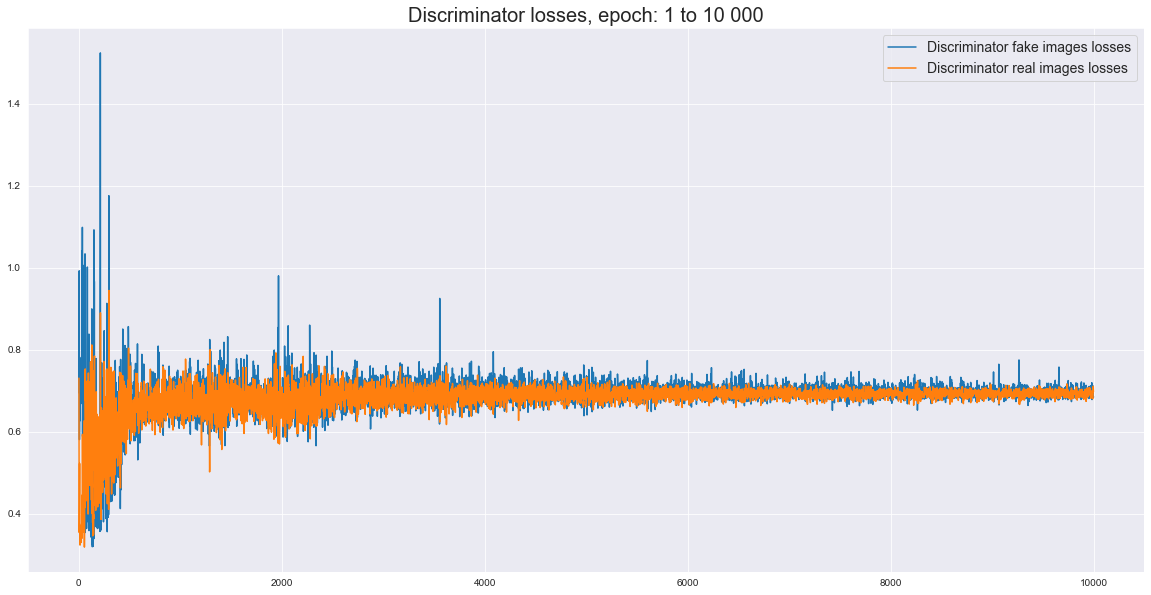

In [81]:
plt.figure(figsize=(20,10))
plt.plot(df['disc_fake_loss'], label='Discriminator fake images losses')
plt.plot(df['disc_real_loss'], label='Discriminator real images losses')
plt.legend(loc=1,prop={'size': 14})
plt.title('Discriminator losses, epoch: 1 to 10 000', fontsize=20)
plt.show()

In [85]:
'''Creating a gif from our generated images''' 

frames = []
imgs = glob.glob(r"D:\projekt_output\Images1\*.png")
for i in imgs:
    new_frame = Image.open(i)
    frames.append(new_frame)
 
frames[0].save(r'D:\projekt_output\Gif\png_to_gif.gif', format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=100, loop=1)

Sample of real and generated images.

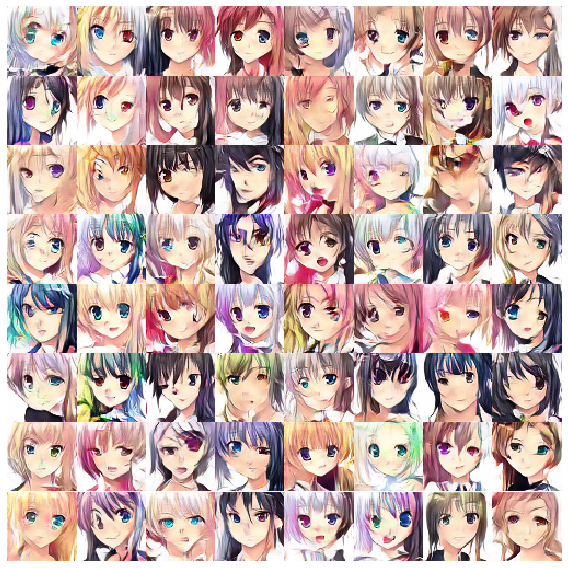

In [79]:
''' Generated images'''
plt.figure(figsize=(8, 8))
gs1 = gs.GridSpec(8, 8)
gs1.update(wspace=0, hspace=0)

random_indices = np.random.choice(fake_data_X.shape[0], 64, replace=False)
for i in range(64):
    ax1 = plt.subplot(gs1[i])
    ax1.set_aspect('equal')
    random_index = random_indices[i]
    image = fake_data_X[random_index, :, :, :]
    fig = plt.imshow(denorm_img(image))
    plt.axis('off')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
plt.tight_layout()
plt.savefig(save_images_dir + str(epoch).zfill(5) + "_image.png", bbox_inches='tight', pad_inches=0)
plt.show()

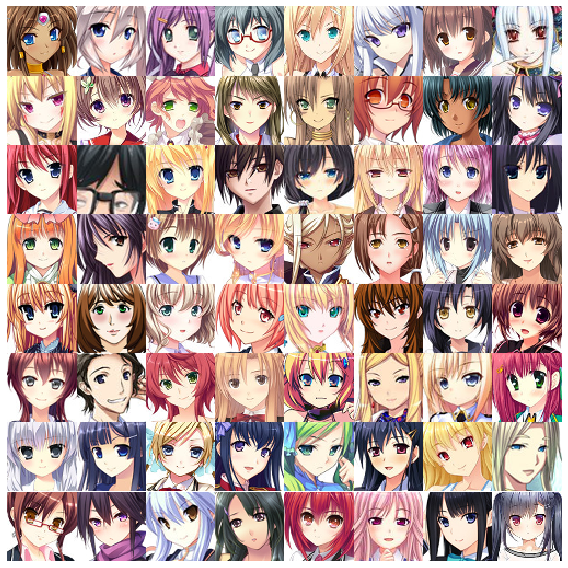

In [80]:
'''Real images'''
plt.figure(figsize=(8, 8))
gs1 = gs.GridSpec(8, 8)
gs1.update(wspace=0, hspace=0)

idx = np.random.randint(0, X.shape[0], batch_size)
real_data_X = X[idx]

for i in range(64):
    ax1 = plt.subplot(gs1[i])
    ax1.set_aspect('equal')
    random_index = random_indices[i]
    image = real_data_X[random_index, :, :, :]
    fig = plt.imshow(denorm_img(image))
    plt.axis('off')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
plt.tight_layout()
plt.savefig(save_gif_dir + "real_image.png", bbox_inches='tight', pad_inches=0)
plt.show()